# PoC: Integrated Gradients


In [ ]:
!pip install -q transformers
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00


In [ ]:
# import required libraries
import pandas as pd
import numpy as np

import torch
from torch.nn import functional as F

import matplotlib.pyplot as plt
%matplotlib inline

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

import copy
import random

In [ ]:
dataset = load_dataset('imdb')

samples = dataset["train"].shuffle(seed=42).select(range(3))

for row in samples:
    print(f"Review: {row['text']}'")
    print(f"Label: {row['label']}")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Review: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...'
Label: 1
Review: This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stub your toe on the 

## Set up helper methods

In [ ]:
def get_sample(dataset, sample_idx):
  assert max(sample_idx) <= len(dataset)
  sample = dataset.shuffle(seed=42).select(sample_idx)
  review = sample['text'][0]
  label = sample['label'][0]
  return review, label

In [ ]:
def get_input_output(sentence, model, tokenizer, labels):
  inputs = tokenizer(sentence, return_tensors='pt')
  outputs = model(**inputs, labels=labels, output_attentions=True, output_hidden_states=True)
  return inputs, outputs

In [ ]:
import copy
def calc_integrated_gradients(inputs, model, baseline, num_steps):
  # get pretrained token embeddings
  input_embed = model.bert.embeddings.word_embeddings.weight
  copy_embed = copy.deepcopy(input_embed.data)

  if baseline is None:
    # create baseline
    baseline = torch.zeros_like(copy_embed)

  grads = []

  for step in range(num_steps + 1):
    input_embed.data =  baseline + step/num_steps * (copy_embed - baseline)
    outputs = model(**inputs, output_hidden_states=True, output_attentions=True)
    logits, hidden_states = outputs.logits, outputs.hidden_states
    logits = logits[0]

    # calculate the derivates of the output of BertEmbedding
    out_embed = hidden_states[0]
    g = torch.autograd.grad(logits, out_embed, grad_outputs=torch.ones_like(logits))[0]
    grads.append(g)

  # stack grads along first dimension to create a new tensor
  grads = torch.stack(grads)

  # approx integral
  grads = (grads[:-1] + grads[1:]) / 2
  avg_grad = grads.mean(0)

  integrated_grads = out_embed * avg_grad

  return integrated_grads

def calc_scores(integrated_grads):
  scores = torch.sqrt((integrated_grads ** 2).sum(-1))
  # normalize scores
  max_s, min_s = scores.max(1, True).values, scores.min(1, True).values
  normalized_scores = (scores - min_s) / (max_s - min_s)
  return normalized_scores[0].tolist()

In [ ]:
def plot_gradients(tokens, gradients, title):
  plt.figure(figsize=(21,3))
  xvals = [ x + str(i) for i,x in enumerate(tokens)]
  colors =  [ (0,0,1, c) for c in (gradients) ]

  plt.tick_params(axis='both', which='minor', labelsize=29)
  p = plt.bar(xvals, gradients, color=colors, linewidth=1 )
  plt.title(title)
  p=plt.xticks(ticks=[i for i in range(len(tokens))], labels=tokens, fontsize=12,rotation=90)

## Define parameters

In [ ]:
review, label = get_sample(dataset['train'], sample_idx=[1])
print(f'Review: {review}\nLabel: {label}')
baseline = None
num_steps = 20 # range between 20 - , depending on the complexity of the model

NameError: ignored

Hypothesis: since the label of the sample sentence is positive (1), we expect large gradient attributions towards positive words in the sentence such as "great", "fun", "inspirational", etc.

# DistilBERT

In [ ]:
def calc_integrated_gradients(inputs, model, baseline, num_steps):
  # get pretrained token embeddings
  if model == "distilbert-base-uncased":
    input_embed = model.base_model.embeddings.word_embeddings(inputs['input_ids'][0])
  else:
    input_embed = model.bert.embeddings.word_embeddings.weight
  copy_embed = copy.deepcopy(input_embed.data)

  if baseline is None:
    # create baseline
    baseline = torch.zeros_like(copy_embed)

  grads = []

  for step in range(num_steps + 1):
    input_embed.data =  baseline + step/num_steps * (copy_embed - baseline)
    outputs = model(**inputs, output_hidden_states=True, output_attentions=True)
    logits, hidden_states = outputs.logits, outputs.hidden_states
    logits = logits[0]

    # calculate the derivates of the output of BertEmbedding
    out_embed = hidden_states[0]
    g = torch.autograd.grad(logits, out_embed, grad_outputs=torch.ones_like(logits))[0]
    grads.append(g)

  # stack grads along first dimension to create a new tensor
  grads = torch.stack(grads)

  # approx integral
  grads = (grads[:-1] + grads[1:]) / 2
  avg_grad = grads.mean(0)

  integrated_grads = out_embed * avg_grad

  return integrated_grads

In [ ]:
distilbert = "distilbert-base-uncased"
distil_tokenizer = AutoTokenizer.from_pretrained(distilbert)
distil_model = AutoModelForSequenceClassification.from_pretrained(distilbert, num_labels=2, return_dict=True)
print(distil_model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
distil_outputs = distil_model(**distil_inputs, labels=labels, output_attentions=True, output_hidden_states=True)
distil_pred = torch.argmax(distil_outputs.logits, dim=-1)
print(f'Review: {review}\nGround Truth Label: {labels}\nPrediction: {distil_pred}')

Review: This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stub your toe on the moon" It reminds me of Sinatra's song High Hopes, it is fun and inspirational. The Music is great throughout and my favorite song is sung by the King, Hank (bing Crosby) and Sir "Saggy" Sagamore. OVerall a great family movie or even a great Date movie. This is a movie you can watch over and over again. The princess played by Rhonda Fleming is gorgeous. I love this movie!! If you liked Danny Kaye in the Court Jester then you will definitely like this movie.
Ground Truth Label: tensor([1])
Prediction: tensor([0])


In [ ]:
distil_inputs, distil_ouputs = get_input_output(review, distil_model, distil_tokenizer)
ig_distil = calc_integrated_gradients(distil_inputs, distil_model, baseline, num_steps)
scores_distil = calc_scores(ig_distil)
tokens_distil= distil_tokenizer.convert_ids_to_tokens(distil_inputs['input_ids'][0])

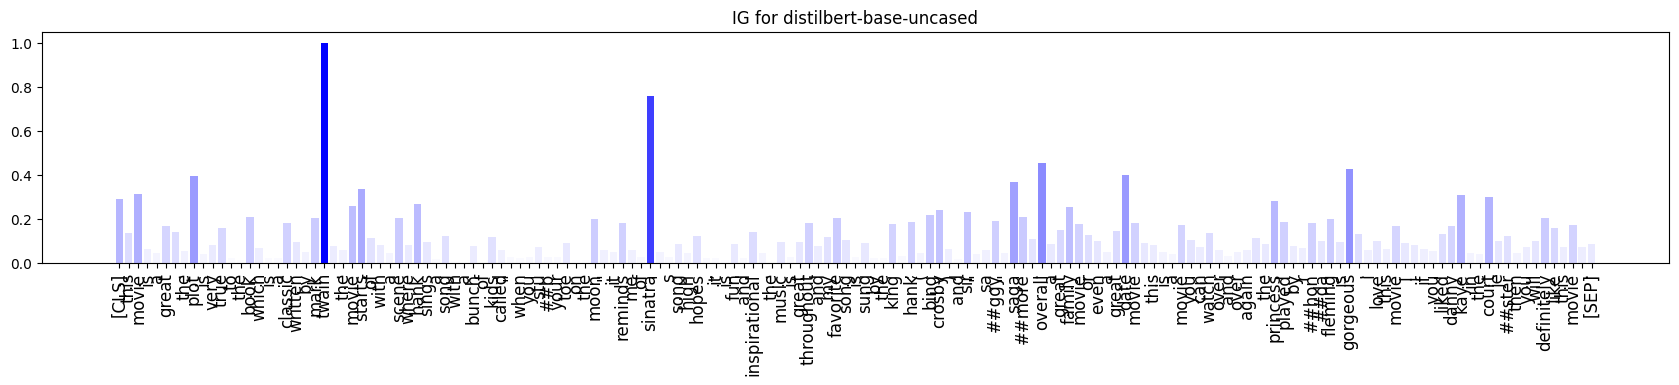

In [ ]:
plot_gradients(tokens_distil, scores_distil, f"IG for {distilbert}")

## BERT-base-uncased

In [ ]:
bert_base = "bert-base-uncased"

base_tokenizer = BertTokenizer.from_pretrained(bert_base)
base_model = BertForSequenceClassification.from_pretrained(bert_base, return_dict=True)

print(base_model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
base_outputs = base_model(**base_inputs, labels=labels, output_attentions=True, output_hidden_states=True)
base_pred = torch.argmax(base_outputs.logits, dim=-1)
print(f'Review: {review}\nGround Truth Label: {labels}\nPrediction: {base_pred}')

Review: This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stub your toe on the moon" It reminds me of Sinatra's song High Hopes, it is fun and inspirational. The Music is great throughout and my favorite song is sung by the King, Hank (bing Crosby) and Sir "Saggy" Sagamore. OVerall a great family movie or even a great Date movie. This is a movie you can watch over and over again. The princess played by Rhonda Fleming is gorgeous. I love this movie!! If you liked Danny Kaye in the Court Jester then you will definitely like this movie.
Ground Truth Label: tensor([1])
Prediction: tensor([0])


In [ ]:
base_inputs, base_outputs = get_input_output(review, base_model, base_tokenizer)
ig_base = calc_integrated_gradients(base_inputs, base_model, baseline, num_steps)
scores_base = calc_scores(ig_base)
tokens_base = base_tokenizer.convert_ids_to_tokens(base_inputs['input_ids'][0])

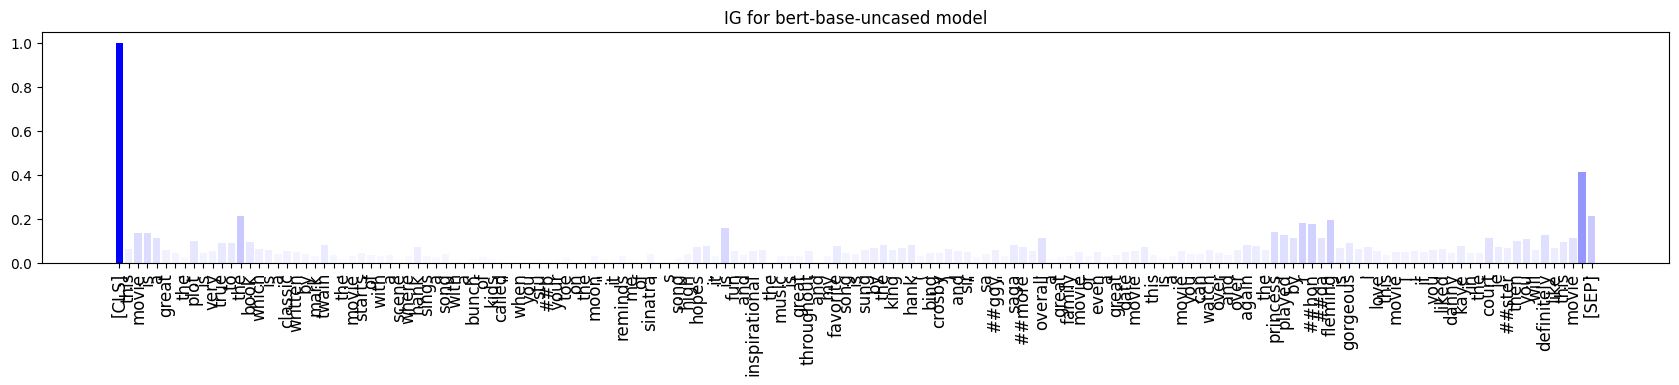

In [ ]:
plot_gradients(tokens_base, scores_base, f'IG for {bert_base} model' )

## BERT-large-uncased

In [ ]:
bert_large = "bert-large-uncased"

large_tokenizer = BertTokenizer.from_pretrained(bert_large)
large_model = BertForSequenceClassification.from_pretrained(bert_large, return_dict=True)
print(large_model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,

In [ ]:
large_outputs = large_model(**large_inputs, labels=labels, output_attentions=True, output_hidden_states=True)
large_pred = torch.argmax(large_outputs.logits, dim=-1)
print(f'Review: {review}\nGround Truth Label: {labels}\nPrediction: {large_pred}')

Review: This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stub your toe on the moon" It reminds me of Sinatra's song High Hopes, it is fun and inspirational. The Music is great throughout and my favorite song is sung by the King, Hank (bing Crosby) and Sir "Saggy" Sagamore. OVerall a great family movie or even a great Date movie. This is a movie you can watch over and over again. The princess played by Rhonda Fleming is gorgeous. I love this movie!! If you liked Danny Kaye in the Court Jester then you will definitely like this movie.
Ground Truth Label: tensor([1])
Prediction: tensor([1])


In [ ]:
large_inputs, large_outputs = get_input_output(review, large_model, large_tokenizer)
ig_large = calc_integrated_gradients(large_inputs, large_model, baseline, num_steps)
scores_large = calc_scores(ig_large)
tokens_large = large_tokenizer.convert_ids_to_tokens(large_inputs['input_ids'][0])

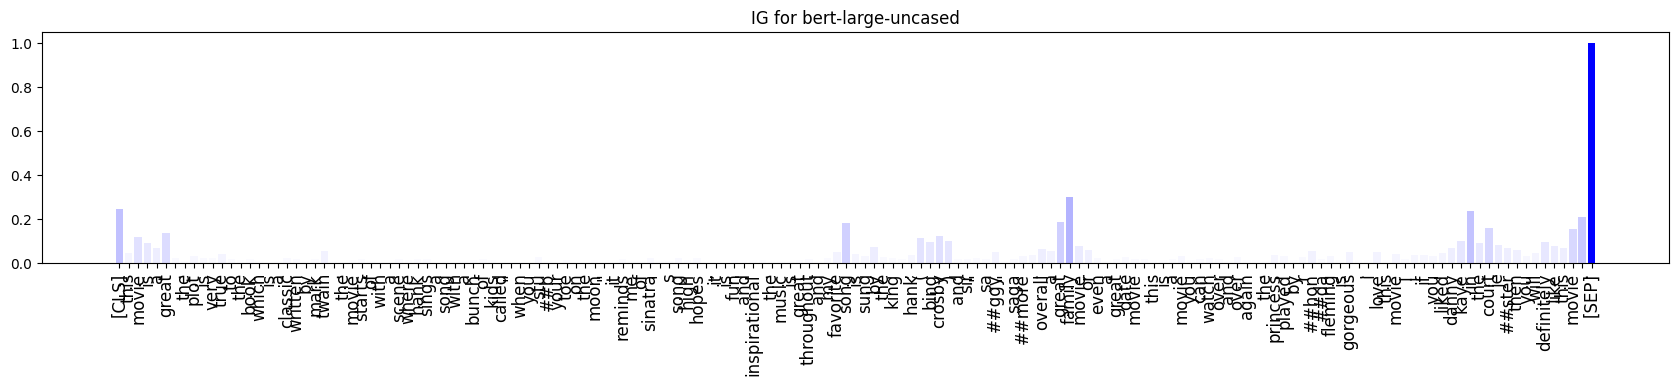

In [ ]:
plot_gradients(tokens_large, scores_large, f'IG for {bert_large}')